# Figure 001 (v001)

KRAS mutation rates and expression across tissues and cell types.

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import re

import janitor  # noqa: F401
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import breezy.plotting as bp
from breezy import data as bd
from breezy.breezy_paths import figure_img_file

In [4]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
bp.set_breezy_theme(bp.PlottingMode.DISSERTATION)

### Data

In [5]:
kras_mut_freq = bd.cbioportal_kras_freq(cancer_type_inorder=True)
kras_mut_freq.head(3)

,cancer_type,alteration_frequency,alteration_type,alteration_count
0,Pancreatic Cancer,4.347826,multiple,8
1,Pancreatic Cancer,59.239130,mutated,109
2,Colorectal Cancer,0.505051,multiple,3


In [6]:
alterations = kras_mut_freq["alteration_type"].cat.categories
alteration_pal = {k: sns.color_palette("tab10")[i] for i, k in enumerate(alterations)}

In [7]:
gtex_expr = bd.gtex_expression_data()
gtex_expr.head(3)

,expr,dataset_id,gencode_id,gene_symbol,source,unit
0,17.12,gtex_v8,ENSG00000133703.11,KRAS,thyroid,TPM
1,13.74,gtex_v8,ENSG00000133703.11,KRAS,thyroid,TPM
2,11.52,gtex_v8,ENSG00000133703.11,KRAS,thyroid,TPM


In [8]:
tm_expr = bd.tabula_muris_data()
tm_expr.head(3)

,cell_id,tissue,cell_type,cell_ontology_class,cell_ontology_id,cluster_ids,free_annotation,mouse_id,mouse_sex,plate_barcode,tissue_tsne_1,tissue_tsne_2,n_genes_by_counts,total_counts,kras_expr,kras_log_expr
0,A21.MAA000594.3_8_M.1.1,aorta,fibroblast,fibroblast,CL:0000057,3,NaN,3_8_M,M,MAA000594,-15.322284,-5.440012,3861,1876233.0,0.0,0.0
1,F8.MAA000594.3_8_M.1.1,aorta,erythrocyte,erythrocyte,CL:0000232,0,NaN,3_8_M,M,MAA000594,7.898756,-6.459818,807,122044.0,0.0,0.0
2,H11.MAA000594.3_8_M.1.1,aorta,erythrocyte,erythrocyte,CL:0000232,0,NaN,3_8_M,M,MAA000594,14.039970,-3.910648,573,369006.0,0.0,0.0


## Figure

### Shared

In [9]:
FIGNUM, VERSION = 1, 1
FIGURE_FILE = figure_img_file(FIGNUM, VERSION, "kras-mut-expr")
FIGURE_FILE

PosixPath('/Users/admin/Developer/haigis-lab/breezy/figures/figure_001-v001/fig_001-v001_kras-mut-expr.png')

In [10]:
FIGSIZE = (6.5, 7.5)
figure = plt.figure(constrained_layout=True, figsize=FIGSIZE)
subfigures = figure.subfigures(
    nrows=3, ncols=1, squeeze=True, height_ratios=(1, 1, 1.2)
)

panel_a = subfigures[0]
panel_b = subfigures[1]
panel_c = subfigures[2]

<Figure size 650x750 with 0 Axes>

### a. *KRAS* mutation frequency across cancer

In [11]:
panel_a.clear()
panel_a.text(0, 0.96, "a", fontsize=8, fontweight="bold")
ax_a = panel_a.subplots()

sns.histplot(
    kras_mut_freq,
    x="cancer_type",
    hue="alteration_type",
    weights="alteration_frequency",
    multiple="stack",
    shrink=0.8,
    palette=alteration_pal,
    alpha=1,
    lw=0,
    ax=ax_a,
)
ax_a.grid(visible=True, axis="x")

xlabels = kras_mut_freq["cancer_type"].cat.categories
xlabels = [x.lower() for x in xlabels]
ax_a.set_xlim(-0.5, len(xlabels) - 0.5)
ax_a.set_xticks(ticks=np.arange(len(xlabels)), labels=xlabels, rotation=25, ha="right")


ax_a.legend(
    handles=bp.pal_to_legend_handles(alteration_pal, marker="s", lw=0),
    title="alteration type",
    loc="upper right",
    handletextpad=1,
    handlelength=0,
    handleheight=0,
    frameon=True,
    edgecolor="w",
)
ax_a.set_ylabel("mutation frequency (%)")
ax_a.set_xlabel("cancer type")

Text(0.5, 0, 'cancer type')

### b. *KRAS* expression in GTEx

In [12]:
def _sort_cats_by_median_column(df: pd.DataFrame, col: str, by: str) -> pd.DataFrame:
    df = df.copy()
    median_order = (
        df.groupby(col)[by]
        .median()
        .reset_index()
        .sort_values(by, ascending=False)[col]
        .values
    )
    df[col] = pd.Categorical(df[col], categories=median_order)
    return df

In [13]:
panel_b.clear()
panel_b.text(0, 0.98, "b", fontsize=8, fontweight="bold")
ax_b = panel_b.subplots()

plot_df = _sort_cats_by_median_column(gtex_expr, "source", "expr")

sns.boxplot(
    data=plot_df,
    x="source",
    y="expr",
    fliersize=1,
    ax=ax_b,
    linewidth=0.8,
    color="#24A2A6",
)
ax_b.set_xticklabels(
    ax_b.get_xticklabels(),
    rotation=40,
    ha="right",
    size=6,
)
ax_b.grid(visible=True, axis="x")
ax_b.set_xlabel("human tissue")
ax_b.set_ylabel("$KRAS$ expression (TPM)")
ax_b.set_ylim(0, None)

(0.0, 63.11953)

### c. *KRAS* expression in mouse

In [17]:
panel_c.clear()
panel_c.text(0, 0.98, "c", fontsize=8, fontweight="bold")
ax_c = panel_c.subplots()

plot_df = _sort_cats_by_median_column(tm_expr, "cell_type", "kras_log_expr")

sns.boxplot(
    data=plot_df,
    x="cell_type",
    y="kras_log_expr",
    fliersize=1,
    linewidth=0.8,
    color="#A4D05F",
    width=0.7,
    ax=ax_c,
)
ax_c.set_ylim(0, None)
ax_c.grid(visible=True, axis="x")


def _clean_mouse_cell_label(lbl: mpl.text.Text) -> mpl.text.Text:
    t = lbl.get_text()
    if not (re.findall("B cell", t) or re.findall("T cell", t)):
        t = re.sub("cell$", "", t).strip()
    lbl.set_text(t)
    return lbl


ax_c_lbls = [_clean_mouse_cell_label(lbl) for lbl in ax_c.get_xticklabels()]
ax_c.set_xticklabels(ax_c_lbls, rotation=65, ha="right", size=5.5)
ax_c.set_xlabel("mouse tissue")
ax_c.set_ylabel("$Kras$ expression\n" + r"$\log($" + "norm. counts" + r"$+1)$")

Text(0, 0.5, '$Kras$ expression\n$\\log($norm. counts$+1)$')

## Saving

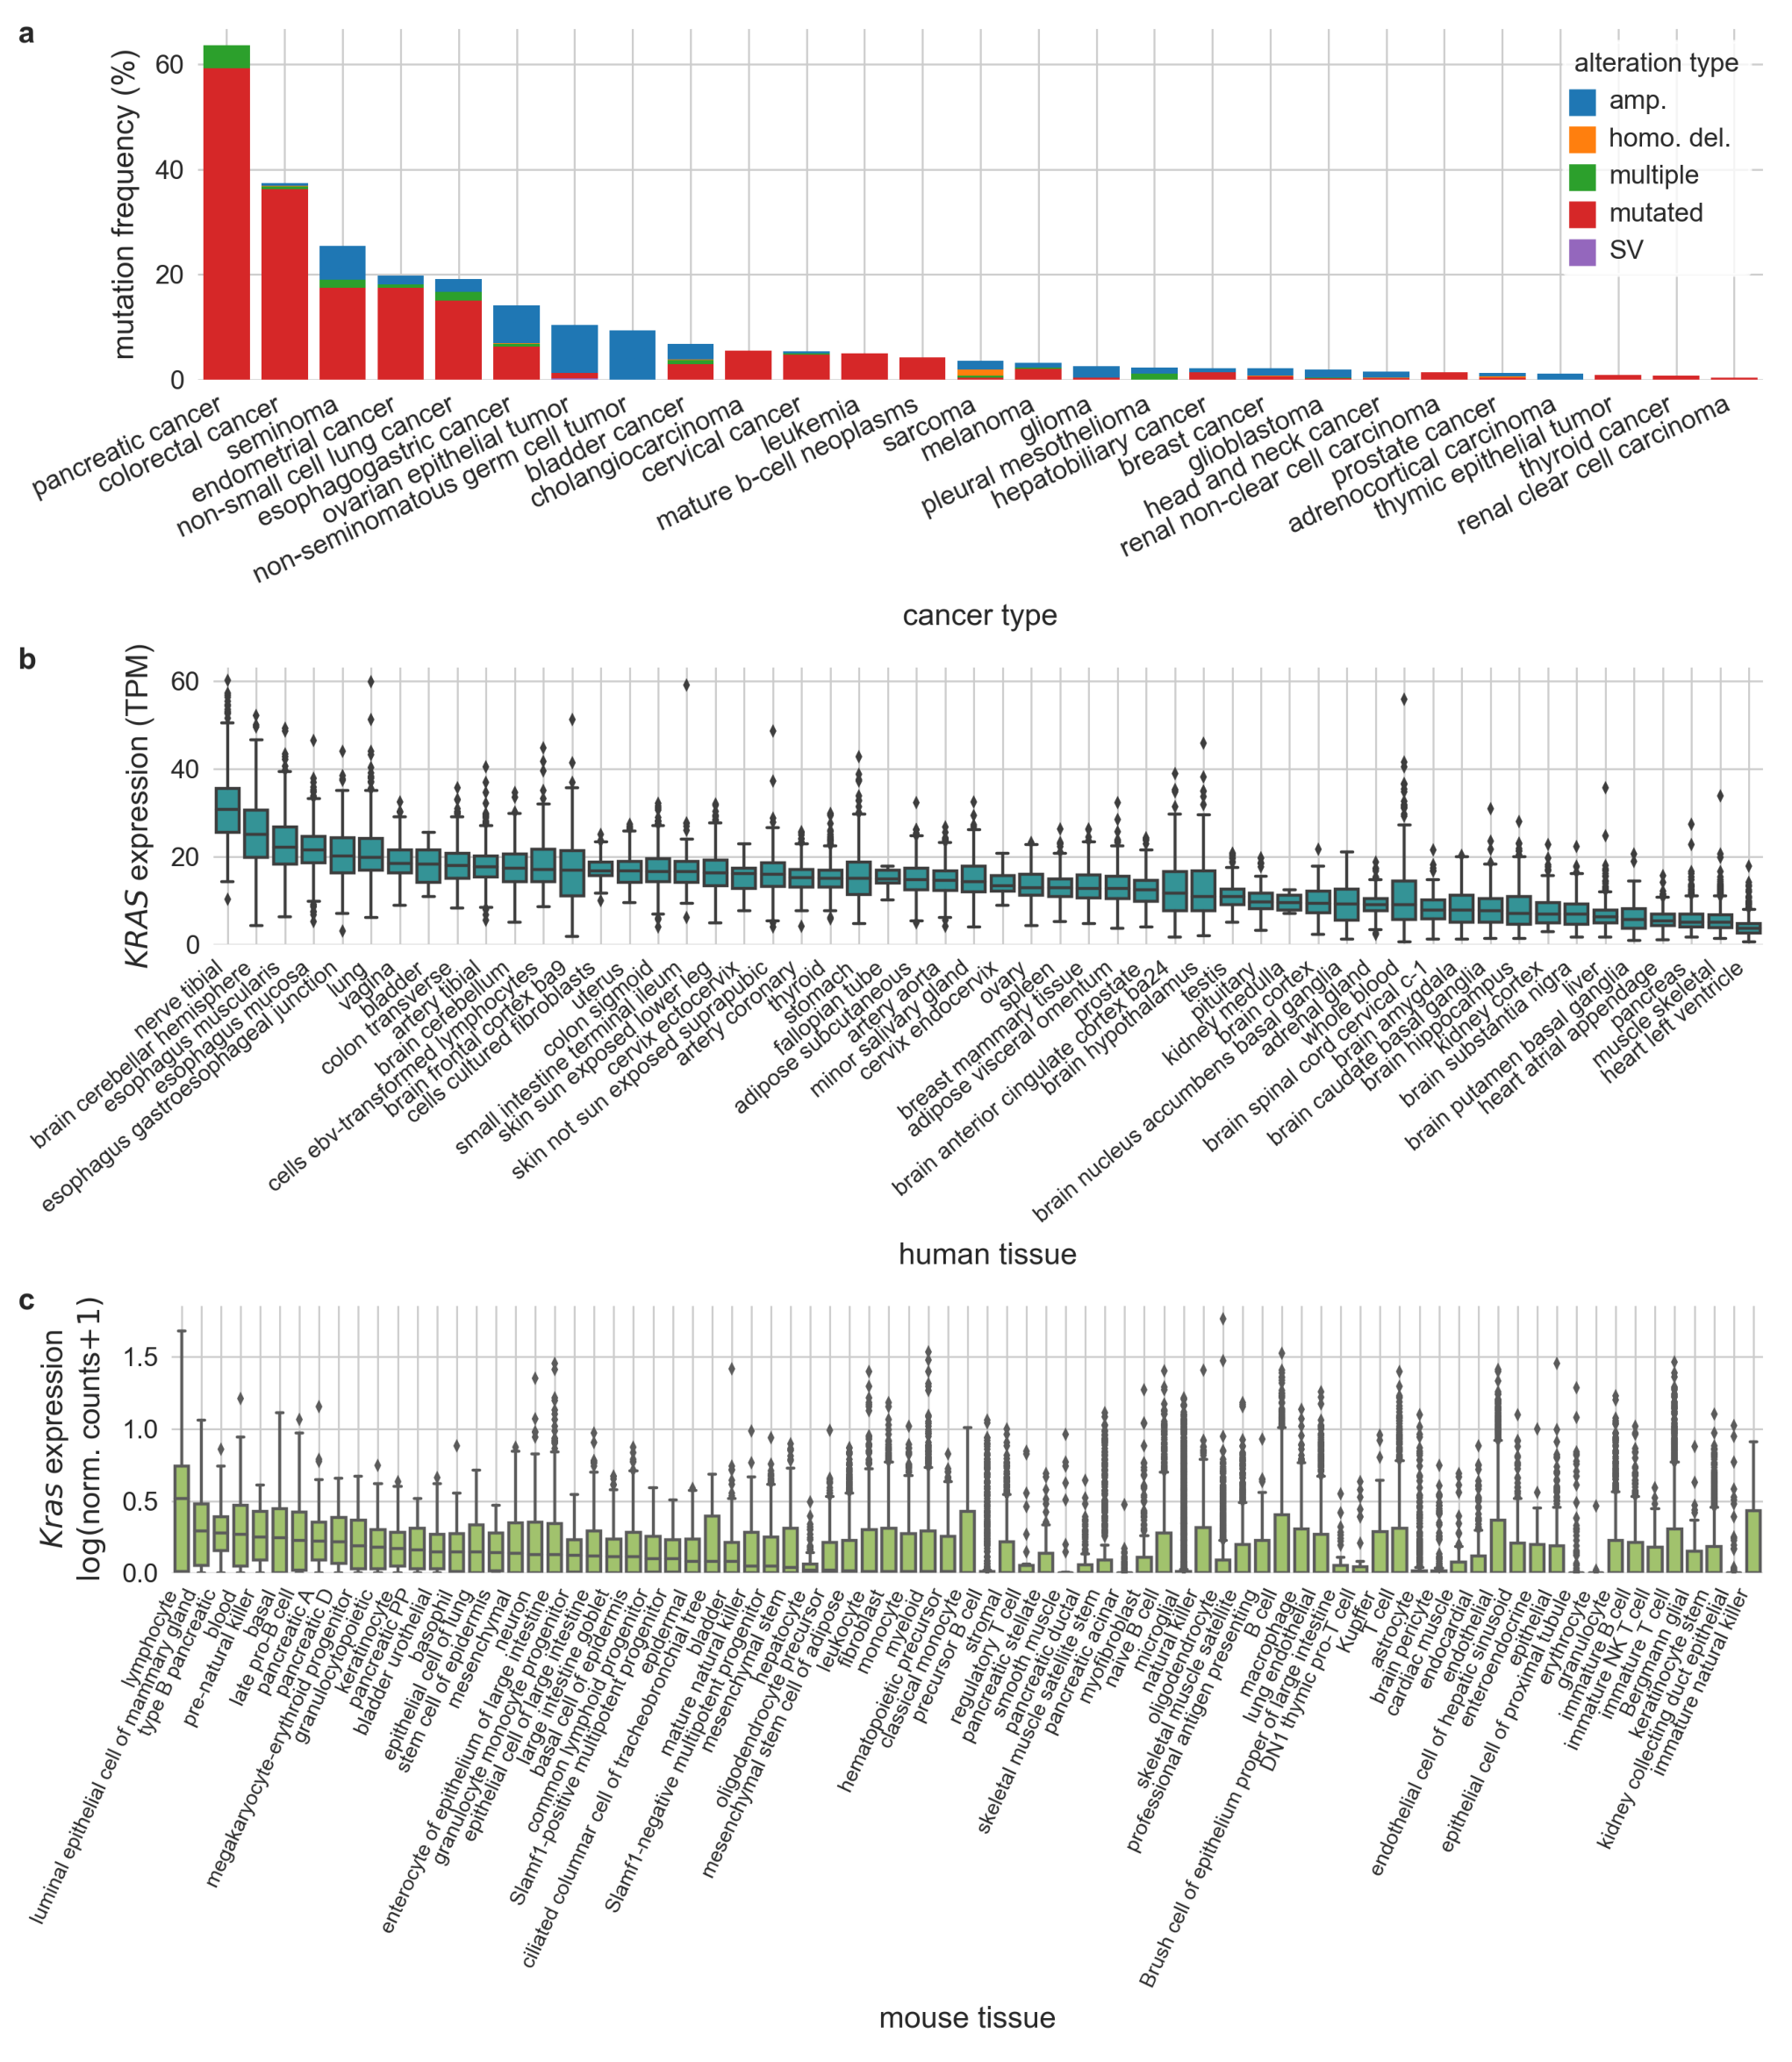

In [18]:
figure.savefig(FIGURE_FILE, dpi=400, pad_inches=0)

fig, ax = plt.subplots(figsize=[x * 2 for x in FIGSIZE])
ax.imshow(plt.imread(FIGURE_FILE))
ax.axis("off")
plt.show()

---

## Session Info

In [19]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-09-15

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

Compiler    : Clang 13.0.1 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: jhcookmac.harvardsecure.wireless.med.harvard.edu

Git branch: figure

breezy    : 0.0.1
re        : 2.2.1
janitor   : 0.22.0
seaborn   : 0.11.2
pandas    : 1.4.4
matplotlib: 3.5.3
numpy     : 1.23.2

